# Spectrogram Analyzer: 
A program that uses ML to learn patterns in spectrograms, and assigns tags/genres to them.
Trained on the MagnaTagATune Dataset. Currently using 10k tracks in training.

Github: https://github.com/bujjujj/Spectrogram-Analyzer

MagnaTagATune Dataset:
https://mirg.city.ac.uk/codeapps/the-magnatagatune-dataset

**Immediate Improvements:**
* Convert all 25.8k mp3s to spectrograms
* Change spectrogram height from 96 to 128
* Train for 50+ epochs instead of 25 (and implement early stop if model stops learning at some point)
* Make CNN layers larger (16, 32, 64... => 32, 64, 128...)

**First Step:**
First three bullet points 

**Second Step:**
Fourth bullet point

In [1]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
import time

import os
import csv
import re
from tqdm import tqdm

print(f"Current directory: {os.getcwd()}")
new_dir_path = r'c:\Users\happy\Downloads\spectrogram_analyzer_project' 
#Ensure we are in the right directory, even if our current directory is already the correct one
try:
    os.chdir(new_dir_path)
    print(f"Successfully changed to: {os.getcwd()}")
except FileNotFoundError:
    print(f"Error: The directory '{new_dir_path}' does not exist.")

Current directory: c:\Users\happy\Downloads\spectrogram_analyzer_project
Successfully changed to: c:\Users\happy\Downloads\spectrogram_analyzer_project


In [34]:
# --- Configuration ---
ANNOTATIONS_PATH = 'annotations_final.csv'
MP3_DIR = 'mp3'
OUTPUT_DIR = 'spectrograms'

# Create the output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
# --- Load Annotations ---

#annotations_final is a very tricky file, we can't just directly pd.read_csv
print("File is tricky. Starting tab-specific manual parsing...")

processed_data = [] 
column_names = []

#Open the file to read it line by line
with open(ANNOTATIONS_PATH, 'r') as f:
    
    #Process the header line to get clean column names
    header_line = f.readline()
    #Remove surrounding quotes from each field and split ONLY by tab
    column_names = [name.strip('"') for name in header_line.strip().split('\t')]
    
    #Process the rest of the file (the data rows)
    for line in f:
        #Skip any blank lines
        if not line.strip():
            continue
            
        #Split the data line ONLY by tab
        values = [val.strip('"') for val in line.strip().split('\t')]
        
        #Create a dictionary for the row. This handles the ragged data issue.
        row_dict = {column_names[i]: val for i, val in enumerate(values)}
        
        #Add the processed row to the list
        processed_data.append(row_dict)
df = pd.DataFrame(processed_data)

#Ensure the columns are in the original order
if column_names:
    df = df[column_names]
    
#df has clip_id and mp3_path, 2 columns that aren't needed for one-hot encoding

non_label_cols = ['clip_id', 'mp3_path']
label_cols = [col for col in df.columns if col not in non_label_cols]
y_labels = df[label_cols].values.astype(np.float32)

for col in label_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

File is tricky. Starting tab-specific manual parsing...


In [ ]:
# --- Testing code for prediction in last notebook cell (answer key)---
row = df[df['clip_id'] == '21888']
tagged_columns = row[row == 1]
tags = tagged_columns.dropna(axis=1).columns.tolist()
print(tags)

['male vocal', 'vocals', 'no piano', 'guitar', 'male voice', 'man', 'pop', 'singing']


In [ ]:
# --- Helper methods for spectrogram generation ---
def get_full_path(relative_path_col):
    #Join the main MP3 directory with the path from the CSV
    return os.path.join(MP3_DIR, relative_path_col)

def create_mel_spectrogram(audio_path, duration=29):
    """
    Generates a standardized Mel-spectrogram from an audio file.
    """
    try:
        y, sr = librosa.load(audio_path, duration=duration, sr=None)
        target_length = int(duration * sr)
        if len(y) < target_length:
            y = np.pad(y, (0, target_length - len(y)), 'constant')
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=96, fmax=sr/2) #n_mels changed from 128 to 96 to speed up training, but ideally will be changed back
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        return log_mel_spectrogram
    except Exception as e:
        print(f"Error processing {os.path.basename(audio_path)}: {e}")
        return None

In [ ]:
# --- Generate spectrograms --- 
print("\nConstructing file paths...")
df = df.copy()
df['path'] = df['mp3_path'].apply(get_full_path)

print("Example file path:", df['path'].iloc[-1])

#Saving spectrograms to output directory
print(f"\nProcessing audio and saving spectrograms to '{OUTPUT_DIR}'...")
spectrogram_generation_start = time.time()
i = 0
spectrogram_num_limit = 10000 #current limit for spectrograms set to the first 10k due to storage restrictions
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Generating Spectrograms"):
    if i == spectrogram_num_limit: 
        break
    i += 1
    audio_path = row['path']
    clip_id = row['clip_id']
    output_path = os.path.join(OUTPUT_DIR, f"{clip_id}.npy")
    if os.path.exists(output_path):
        continue
    mel_spec = create_mel_spectrogram(audio_path)
    if mel_spec is not None:
        np.save(output_path, mel_spec)

spectrogram_generation_end = time.time()
print("\nProcessing complete!")
spectrogram_generation_time = spectrogram_generation_end - spectrogram_generation_start
print(f"Spectrogram generation took {spectrogram_generation_time} seconds.")

print("\nStopped the processing of the data early, as it was taking up too much storage.")
print(f"The first 10000 out of 25863 tracks were processed and spectrograms were created for them ({spectrogram_num_limit/25863}% of total data)")


C:\Users\happy\AppData\Local\Temp\ipykernel_25292\952133810.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['path'] = df['mp3_path'].apply(get_full_path)



Constructing file paths...
Example file path: mp3\8/jacob_heringman-blame_not_my_lute-58-a_toy_for_monica_bishop-0-29.mp3

Processing audio and saving spectrograms to 'spectrograms'...


Generating Spectrograms:  39%|███▊      | 10000/25863 [17:14<27:21,  9.66it/s] 


Processing complete!
Spectrogram generation took 1034.9194328784943 seconds

Stopped the processing of the data early, as it was taking up too much storage.
The first 10000 out of 25863 tracks were processed and spectrograms were created for them (39% of total data)



Visualizing example spectrogram to check output: spectrograms\2.npy


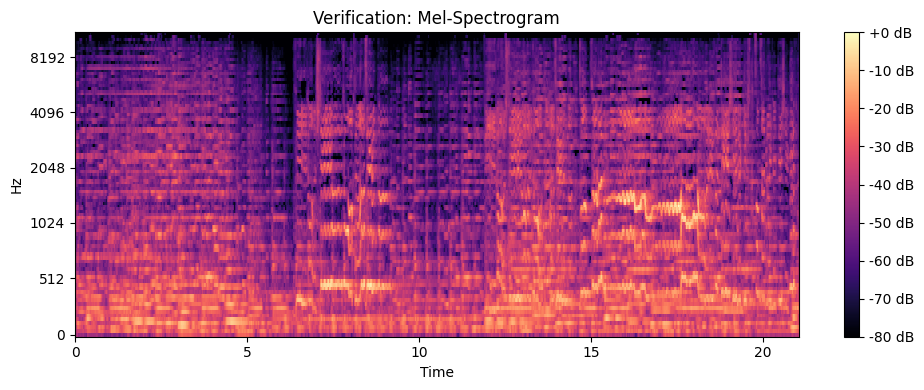

In [ ]:
# --- Ensure the spectrograms are coming out as expected ---
def visualize_spectrogram(npy_path):
    """Loads and displays a spectrogram from a .npy file to verify output."""
    if not os.path.exists(npy_path):
        print(f"File not found: {npy_path}")
        return
    spec = np.load(npy_path)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spec, sr=22050, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Verification: Mel-Spectrogram')
    plt.tight_layout()
    plt.show()

first_clip_id = df['clip_id'].iloc[0]
example_npy_path = os.path.join(OUTPUT_DIR, f"{first_clip_id}.npy")
print(f"\nVisualizing example spectrogram to check output: {example_npy_path}")
visualize_spectrogram(example_npy_path)

In [ ]:
# --- Quick look into df ---
print(f"Shape of our labels (songs, unique_tags): {y_labels.shape}")
print("Labels prepared successfully.")
df[label_cols]

Shape of our labels (songs, unique_tags): (25863, 188)
Labels prepared successfully.


,no voice,singer,duet,plucking,hard rock,world,bongos,harpsichord,female singing,clasical,...,female singer,rap,metal,hip hop,quick,water,baroque,women,fiddle,english
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25858,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25859,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25860,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25861,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# --- Reorganize df ---
# Ideally a temporary section; this is only here because the dataset has 25863 mp3s but due to storage limitations only 10k of them have been converted to spectrograms.
print(f"Original number of samples: {len(df)}")

#Create a function to check if a spectrogram file exists for a given clip_id
def spectrogram_exists(clip_id):
    path = os.path.join(OUTPUT_DIR, f"{clip_id}.npy")
    return os.path.exists(path)

#Apply this function to create a 'True'/'False' column
df['spec_exists'] = df['clip_id'].apply(spectrogram_exists)

#Filter the DataFrame to keep only the rows where the file exists
df = df[df['spec_exists']].copy()

#Dropping the helper column
df.drop(columns=['spec_exists'], inplace=True)

print(f"Number of samples with existing spectrograms: {len(df)}")

Original number of samples: 25863
Number of samples with existing spectrograms: 10000


In [ ]:
# --- Build the data pipeline ---
#Create lists of file paths and their corresponding labels
file_paths = [os.path.join(OUTPUT_DIR, f"{clip_id}.npy") for clip_id in df['clip_id']]

#Drop 'path' in addition to the other two, as it was the helper column that was used for spectrogram generation
non_label_cols = ['clip_id', 'mp3_path', 'path']
label_cols = [col for col in df.columns if col not in non_label_cols]
labels = df[label_cols].values.astype(np.float32)

#Create a TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

def load_and_preprocess(file_path, label):
    spectrogram = np.load(file_path.numpy())
    spectrogram = tf.expand_dims(spectrogram, axis=-1) #Add channel dimension
    return spectrogram, label

def map_func(file_path, label):
    spectrogram, label = tf.py_function(
        load_and_preprocess,
        [file_path, label],
        [tf.float32, tf.float32]
    )

    num_classes = label.shape[0] 
    spectrogram.set_shape([96, None, 1]) #Shape: (height, width, channels)  |  NOTE: height should always correspond to n_mels value in create_mel_spectrogram
    label.set_shape([num_classes])       #Shape: (number_of_tags,)

    return spectrogram, label

#Build the final pipeline

#Shuffle and map the entire dataset of individual files
DATASET_SIZE = len(df) # len(df) is the number of samples
dataset = dataset.shuffle(buffer_size=DATASET_SIZE)
dataset = dataset.map(map_func, num_parallel_calls=tf.data.AUTOTUNE)

#Split the dataset into training and validation sets
train_size = int(0.8 * DATASET_SIZE)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

#Batch and prefetch the training and validation sets separately
batch_size = 32
train_dataset = train_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

print("TensorFlow training and validation pipelines created successfully.")

TensorFlow training and validation pipelines created successfully.


In [ ]:
#Define the file path where the best model will be saved
checkpoint_filepath = 'best_music_model.keras'

#Create the ModelCheckpoint callback
#It will monitor the validation loss and save only the best model
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',      # Monitor the loss on the validation set
    mode='min',              # We want to minimize the loss
    save_best_only=True      # Only save the model if val_loss has improved
)

In [ ]:
# --- Build and train CNN model ---
#Get number of classes from label, and define the input_shape manually
num_classes = labels.shape[1]
input_shape = (96, None, 1)

#CNN layers go from 16, 32, 64..., but ideally will be reverted to 32, 63, 128...
model = models.Sequential([
    layers.InputLayer(shape=input_shape),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.GlobalAveragePooling2D(), #Using GlobalAveragePooling instead of Flatten because we just need to detect the presence of an audio feature, not exactly where it is in the song
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='sigmoid') #Sigmoid for multi-label
])

#Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy', #Loss for multi-label
              metrics=['AUC'])

model.summary()

#Train the model, now with the callback and validation data
print("\nStarting model training...")

model_training_time_start = time.time()
#Maybe also implement an early stop feature, where it's clear that the model has stopped learning and more epochs wouldn't help
history = model.fit(
    train_dataset,
    epochs=25, #can be improved to 50+ for more learning
    validation_data=val_dataset,
    callbacks=[checkpoint_callback]  #Callback is passed here so I have checkpoints
)
model_training_time_end = time.time()
total_model_training_time = model_training_time_end - model_training_time_start

print(f"\nTraining complete! The best model was saved to {checkpoint_filepath}")
print(f"Total model training time was: {total_model_training_time} seconds.")


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 94, None, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 47, None, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 47, None, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 45, None, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 22, None, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 22, None, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 20, None, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, None, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 188)            │        24,252 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,060 (218.98 KB)

 Trainable params: 55,964 (218.61 KB)

 Non-trainable params: 96 (384.00 B)


Starting model training...
Epoch 1/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 156s 610ms/step - AUC: 0.7119 - loss: 0.1239 - val_AUC: 0.8456 - val_loss: 0.0727
Epoch 2/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 170s 678ms/step - AUC: 0.8263 - loss: 0.0753 - val_AUC: 0.8676 - val_loss: 0.0687
Epoch 3/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 173s 693ms/step - AUC: 0.8473 - loss: 0.0719 - val_AUC: 0.7229 - val_loss: 0.0969
Epoch 4/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 139s 556ms/step - AUC: 0.8601 - loss: 0.0694 - val_AUC: 0.8230 - val_loss: 0.0780
Epoch 5/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 128s 510ms/step - AUC: 0.8710 - loss: 0.0680 - val_AUC: 0.7457 - val_loss: 0.0890
Epoch 6/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 144s 577ms/step - AUC: 0.8801 - loss: 0.0658 - val_AUC: 0.8330 - val_loss: 0.0759
Epoch 7/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 226s 671ms/step - AUC: 0.8868 - loss: 0.0649 - val_AUC: 0.8310 - val_loss: 0.0745
Epoch 8/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 167s 668ms/step - AUC: 0.8919 - loss: 0.0632 - val_AUC: 0.8561 - val_loss: 0.0

In [ ]:
# --- Predict ---
#1. Load a spectrogram you want to predict; 
# in the future, ideally this will have some sort of UI where the user can upload an mp3.
# The program will then convert the mp3 to a spectrogram and analyze it.
spectrogram_path = 'spectrograms/21888.npy'
spec = np.load(spectrogram_path)

#2. Reshape it to include a batch dimension and channel dimension
#Adds batch dimension -> (1, height, width)
spec_for_prediction_withBatchDim = np.expand_dims(spec, axis=0) #tells our model how many inputs to expect at once, in this case only 1 because we're predicting
#Adds channel -> (1, height, width, 1)
spec_for_prediction_withBatchAndChannelDim = np.expand_dims(spec_for_prediction_withBatchDim, axis=-1) 

#3. Get the prediction (vector of probabilities)
predicted_probabilities = model.predict(spec_for_prediction_withBatchAndChannelDim)[0]

#4. Use a hybrid method of getting top 7 tags, then providing a minimum probability threshold to find result tags
k = 7

sorted_indices = np.argsort(predicted_probabilities)[::-1] #sorted from greatest probability to least
top_k_indices = sorted_indices[:k] #get top k tags
min_threshold = 0.2

predicted_tags = []
for i in top_k_indices:
    if predicted_probabilities[i] > min_threshold:
        predicted_tags.append((label_cols[i], predicted_probabilities[i]))
print(f"Predicted tags for the song: {predicted_tags}")
#Output will show the predicted tags for the song, alongside the "confidence" level (probability)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predicted tags for the song: [('guitar', np.float32(0.3451857)), ('slow', np.float32(0.2283337)), ('male', np.float32(0.22207446)), ('vocal', np.float32(0.21808332)), ('man', np.float32(0.2097502)), ('male vocal', np.float32(0.2024194))]
